In [319]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
%load_ext autoreload
%autoreload 2
import json

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### load data

In [320]:
file_name = "./data/raw/ATIS/train.json"
with open(file_name) as f:
    data = json.load(f)
data = data['rasa_nlu_data']['common_examples']

In [321]:
index = 0
corpus = []
intent_list = []
for item in data:
    if index <= 5:
        print("=======================")
        print(f"text: {item['text']}")
        print(f"intent: {item['intent']}")

    corpus.append(item['text'])
    intent_list.append(item['intent'])
    index += 1

text: i want to fly from boston at 838 am and arrive in denver at 1110 in the morning
intent: flight
text: what flights are available from pittsburgh to baltimore on thursday morning
intent: flight
text: what is the arrival time in san francisco for the 755 am flight leaving washington
intent: flight_time
text: cheapest airfare from tacoma to orlando
intent: airfare
text: round trip fares from pittsburgh to philadelphia under 1000 dollars
intent: airfare
text: i need a flight tomorrow from columbus to minneapolis
intent: flight


### load embedding model

In [322]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, DBSCAN
from sentence_transformers import SentenceTransformer

In [323]:

embed_model = SentenceTransformer("all-MiniLM-L6-v2")

### embedding

In [324]:
corpus_embeddings = embed_model.encode(corpus)

### K-mean clustering on embedding vector

In [325]:
### note from https://github.com/UKPLab/sentence-transformers/blob/master/examples/applications/clustering/kmeans.py

### kmean clustering
num_clusters = len(set(intent_list))
clustering_model = KMeans(n_clusters=num_clusters)
clustering_model.fit(corpus_embeddings)

### collect the assigned cluster label
cluster_assignment = clustering_model.labels_

### prep the data for visualization
clustered_sentences = [[] for i in range(num_clusters)]
for sentence_id, cluster_id in enumerate(cluster_assignment):
    clustered_sentences[cluster_id].append((corpus[sentence_id], intent_list[sentence_id]))

### 2-d visualization of the embedding clustering

In [326]:
tsne = TSNE(n_components=2)
embeddings_2d = tsne.fit_transform(corpus_embeddings)

In [327]:
### make into dataframe
df = pd.DataFrame({
    'Dimension 1': embeddings_2d[:, 0],
    'Dimension 2': embeddings_2d[:, 1],
    'Cluster': cluster_assignment,
    'True_cluster' : intent_list
})

### color palette for scatter plot
palette = sns.color_palette('hsv', len(set(cluster_assignment)))

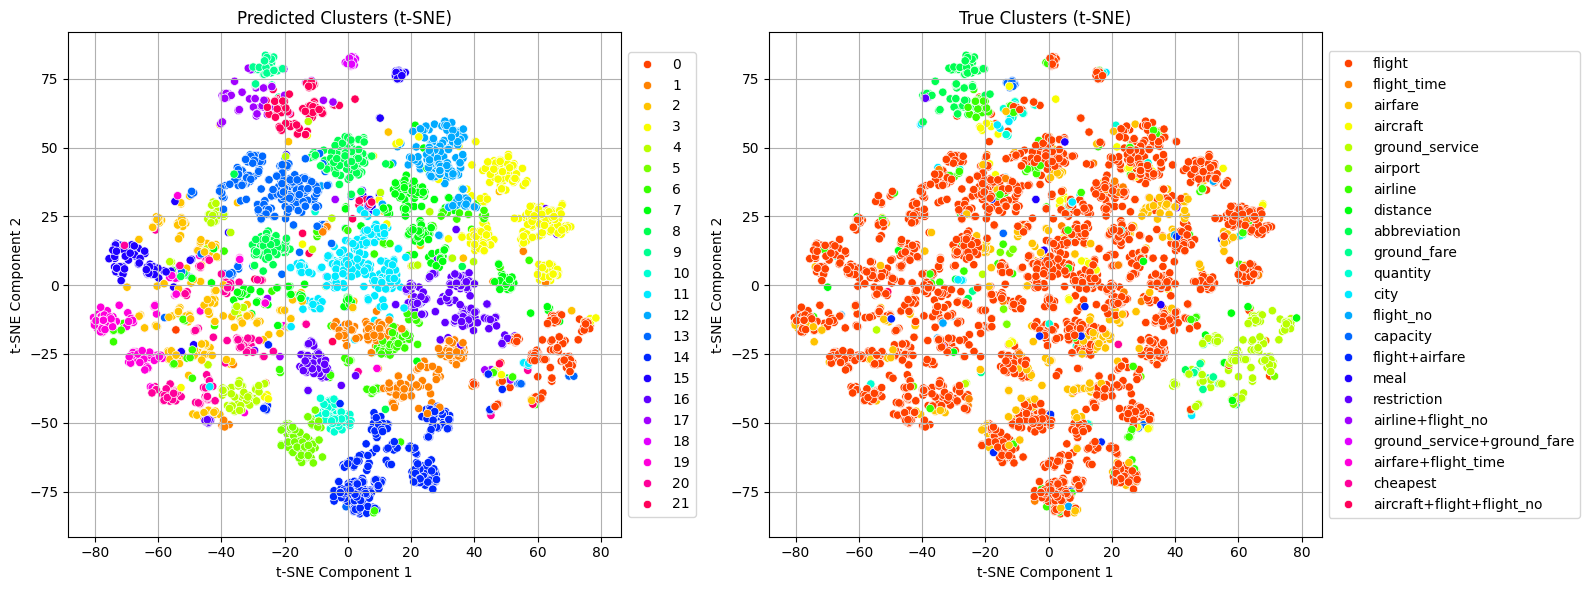

In [328]:
# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

### plot the predicted cluster
sns.scatterplot(ax=axes[0], x='Dimension 1', y='Dimension 2', hue='Cluster', palette=palette, data=df)
axes[0].set_title('Predicted Clusters (t-SNE)')
axes[0].set_xlabel('t-SNE Component 1')
axes[0].set_ylabel('t-SNE Component 2')
axes[0].grid(True)

# plot the true cluster
sns.scatterplot(ax=axes[1], x='Dimension 1', y='Dimension 2', hue='True_cluster', palette=palette, data=df)
axes[1].set_title('True Clusters (t-SNE)')
axes[1].set_xlabel('t-SNE Component 1')
axes[1].set_ylabel('t-SNE Component 2')
axes[1].grid(True)

### move the legned to outside the plot
axes[0].legend(loc='center left', bbox_to_anchor=(1, 0.5))
axes[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

not very precise due to the nature of K-mean (circular cluster)

### DBScan instead of Kmean clustering

In [329]:
### param note
### eps: min distance for 2 point to be considered neighbor
### min_samples: min number of neighbor for point to be considered core point
dbscan = DBSCAN(eps=0.2, min_samples=10, metric="cosine")
db_clusters = dbscan.fit_predict(corpus_embeddings)

In [330]:
### chek number of cluster assigned by DBScan
np.unique(db_clusters)

array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
       16, 17, 18, 19], dtype=int64)

In [360]:
### make into dataframe
df = pd.DataFrame({
    'Dimension 1': embeddings_2d[:, 0],
    'Dimension 2': embeddings_2d[:, 1],
    'Cluster': db_clusters,
    'True_cluster' : intent_list
})

### color palette for scatter plot
palette = sns.color_palette('hsv', len(set(db_clusters)))

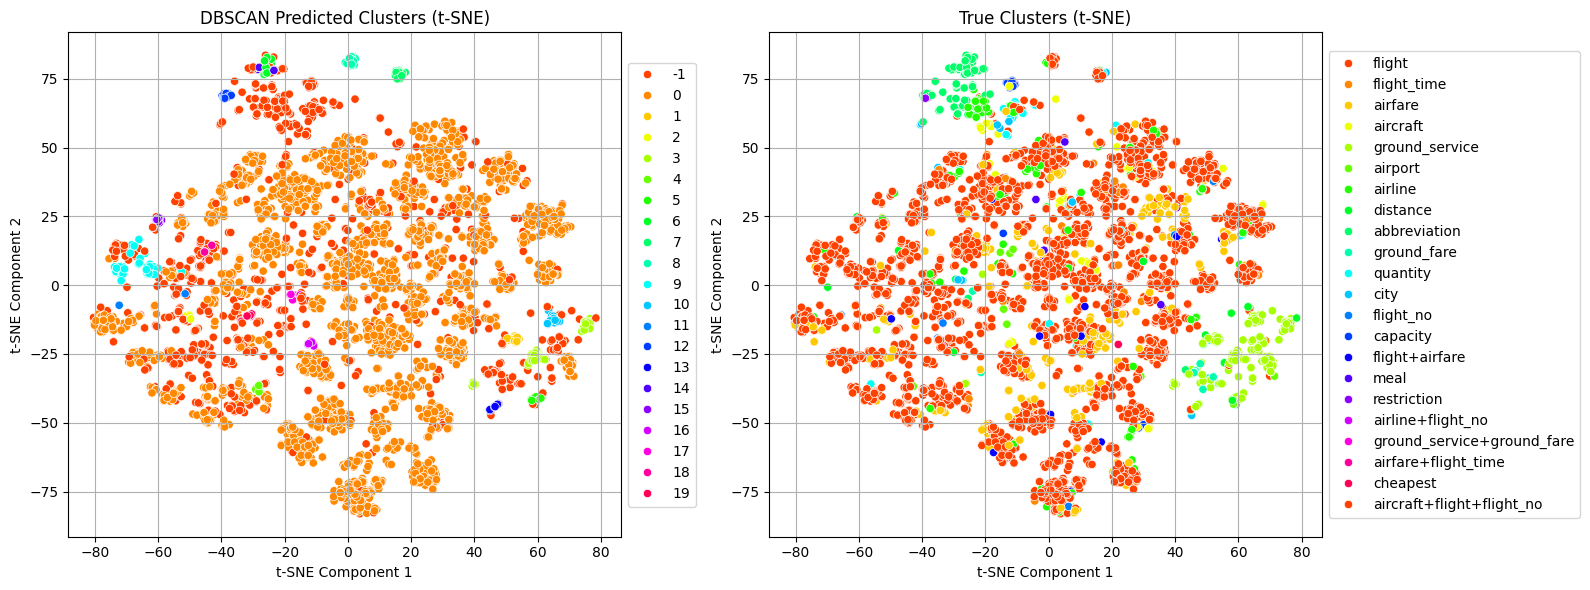

In [361]:
# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

### plot the predicted cluster
sns.scatterplot(ax=axes[0], x='Dimension 1', y='Dimension 2', hue='Cluster', palette=palette, data=df)
axes[0].set_title('DBSCAN Predicted Clusters (t-SNE)')
axes[0].set_xlabel('t-SNE Component 1')
axes[0].set_ylabel('t-SNE Component 2')
axes[0].grid(True)

# plot the true cluster
sns.scatterplot(ax=axes[1], x='Dimension 1', y='Dimension 2', hue='True_cluster', palette=palette, data=df)
axes[1].set_title('True Clusters (t-SNE)')
axes[1].set_xlabel('t-SNE Component 1')
axes[1].set_ylabel('t-SNE Component 2')
axes[1].grid(True)

### move the legned to outside the plot
axes[0].legend(loc='center left', bbox_to_anchor=(1, 0.5))
axes[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

a better match than K-mean, but has some unassigned data point (cluster == -1).
would also need to finetune the hyperparameter

### IterDBScan

In [333]:
from remaking.ITER_DBSCAN import ITER_DBSCAN
from remaking.evaluation import EvaluateDataset

In [334]:
### set model hyperparameter
model = ITER_DBSCAN(initial_distance=0.1126, initial_minimum_samples=10, delta_distance=0.015, delta_minimum_samples=2, max_iteration=40)
# model = ITER_DBSCAN(initial_distance=0.12, initial_minimum_samples=20, delta_distance=0.05, delta_minimum_samples=1, max_iteration=20)
### fit the cluster
iter_clusters = model.fit_predict(corpus_embeddings.tolist())


In [362]:
### make into dataframe
df = pd.DataFrame({
    'Dimension 1': embeddings_2d[:, 0],
    'Dimension 2': embeddings_2d[:, 1],
    'Cluster': iter_clusters,
    'True_cluster' : intent_list
})

### color palette for scatter plot
palette = sns.color_palette('hsv', len(set(iter_clusters)))
true_palette = sns.color_palette('hsv', len(set(cluster_assignment)))

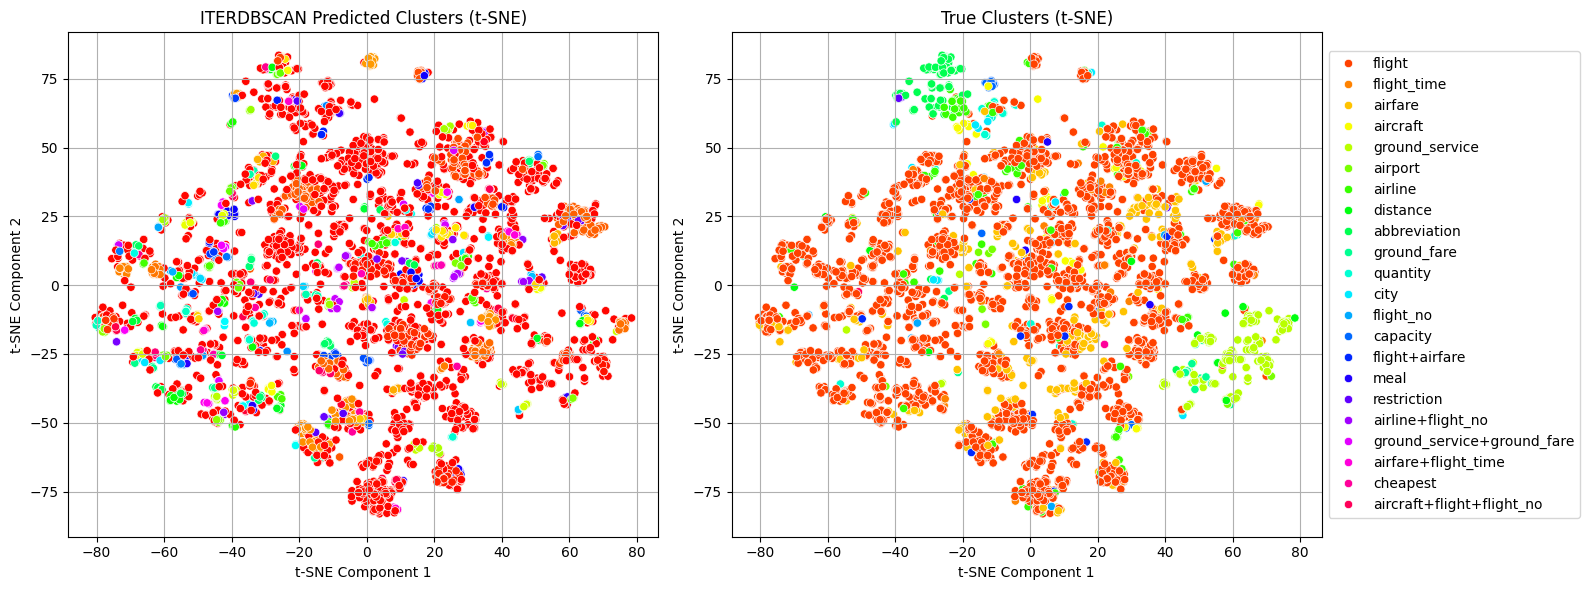

In [363]:
# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

### plot the predicted cluster
sns.scatterplot(ax=axes[0], x='Dimension 1', y='Dimension 2', hue='Cluster', palette=palette, data=df)
axes[0].set_title('ITERDBSCAN Predicted Clusters (t-SNE)')
axes[0].set_xlabel('t-SNE Component 1')
axes[0].set_ylabel('t-SNE Component 2')
axes[0].grid(True)

# plot the true cluster
sns.scatterplot(ax=axes[1], x='Dimension 1', y='Dimension 2', hue='True_cluster', palette=true_palette, data=df)
axes[1].set_title('True Clusters (t-SNE)')
axes[1].set_xlabel('t-SNE Component 1')
axes[1].set_ylabel('t-SNE Component 2')
axes[1].grid(True)

### move the legned to outside the plot
# axes[0].legend(loc='center left', bbox_to_anchor=(1, 0.5))
axes[0].legend([],[], frameon=False) # remove the legend, there was too many
axes[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

In [337]:
f"{(iter_clusters).count(-1) / len(iter_clusters) * 100 :.2f}% are noise"

'45.18% are noise'

## dealing with missing label
cluster == -1 in DBScan or IterDBScan

First method is simply running classification model  
+ using text embedding as 'x' and the valid cluster label as 'y' for training data

Second method is complicated and performed as followed
1. generate a candidate intent
    + this is done by using keyword extraction on sample text data from each cluster
    + remove the entity name from the initially generated intent
2. use zero-shot classifer on text without valid cluster



### Keyword extraction

simple keyword extraction that will be used for generating candidate intent label

In [338]:
from summary import KeyphraseExtractionPipeline
model = "ml6team/keyphrase-extraction-kbir-openkp"
extractor = KeyphraseExtractionPipeline(model=model)

In [339]:
keyphrases = extractor(corpus[:5])
for i, v in enumerate(keyphrases):
    print(f"text: {corpus[i]}, key: {v}")

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


text: i want to fly from boston at 838 am and arrive in denver at 1110 in the morning, key: ['boston']
text: what flights are available from pittsburgh to baltimore on thursday morning, key: ['baltimore' 'flights' 'pittsburgh']
text: what is the arrival time in san francisco for the 755 am flight leaving washington, key: ['arrival time' 'san francisco']
text: cheapest airfare from tacoma to orlando, key: ['cheapest airfare' 'orlando' 'tacoma']
text: round trip fares from pittsburgh to philadelphia under 1000 dollars, key: ['philadelphia' 'pittsburgh' 'round trip fares']


we sample 5 random data point from the cluster and add the data point closest to the centriod.

In [340]:
from summary import closest_point_to_centroid
intent = 7
test_corpus = np.array(corpus)
cluster_corpus = test_corpus[db_clusters == intent]
print(f"num data = {(db_clusters == intent).sum()}")
sampled_data = np.random.choice(cluster_corpus, size=5, replace=False)
closest_point , closest_index = closest_point_to_centroid(corpus_embeddings[db_clusters == intent])
sample_data = np.append(sampled_data, [cluster_corpus[closest_index]], axis=0)
sample_data

num data = 29


array(['list all the flights that fly into general mitchell international',
       'what flights from any city land at general mitchell international',
       'please list the flights taking off and landing on general mitchell international airport',
       'list all the flights that depart from general mitchell international',
       'list all the flights that arrive at general mitchell international',
       'list all the flights that arrive at general mitchell international'],
      dtype='<U259')

apply keyword extraction on the sample data

In [341]:
keyphrases = extractor(sample_data.tolist())
for i, v in enumerate(keyphrases):
    print(f"text: {sample_data[i]}, key: {v}")

text: list all the flights that fly into general mitchell international, key: ['mitchell international']
text: what flights from any city land at general mitchell international, key: ['flights' 'mitchell']
text: please list the flights taking off and landing on general mitchell international airport, key: ['general mitchell international airport']
text: list all the flights that depart from general mitchell international, key: ['general mitchell international']
text: list all the flights that arrive at general mitchell international, key: ['flights' 'general mitchell international']
text: list all the flights that arrive at general mitchell international, key: ['flights' 'general mitchell international']


In [342]:
for i, v in enumerate(keyphrases):
    print(f"{v}")

['mitchell international']
['flights' 'mitchell']
['general mitchell international airport']
['general mitchell international']
['flights' 'general mitchell international']
['flights' 'general mitchell international']


In [343]:
from summary import generate_candidate_intent
candidate_intent = generate_candidate_intent(corpus, corpus_embeddings, db_clusters)
candidate_intent = list(set(candidate_intent))
candidate_intent

Some weights of the model checkpoint at dslim/bert-base-NER-uncased were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


['ittsburgh+transportation',
 'fare code',
 'ground transportation',
 'restriction',
 'aircraft',
 'flight',
 'airport+transportation']

### Run zero-shot classification on missing label

In [344]:
from transformers import pipeline
classifier = pipeline("zero-shot-classification",
                      model="facebook/bart-large-mnli")
    
sequence_to_classify = corpus[:3]
classifier(sequence_to_classify, candidate_intent)

[{'sequence': 'i want to fly from boston at 838 am and arrive in denver at 1110 in the morning',
  'labels': ['flight',
   'airport+transportation',
   'fare code',
   'ittsburgh+transportation',
   'restriction',
   'aircraft',
   'ground transportation'],
  'scores': [0.3696586787700653,
   0.3178068995475769,
   0.11499328911304474,
   0.07142796367406845,
   0.06589435786008835,
   0.05450814589858055,
   0.0057107009924948215]},
 {'sequence': 'what flights are available from pittsburgh to baltimore on thursday morning',
  'labels': ['ittsburgh+transportation',
   'airport+transportation',
   'flight',
   'fare code',
   'restriction',
   'aircraft',
   'ground transportation'],
  'scores': [0.40050965547561646,
   0.28417348861694336,
   0.22166277468204498,
   0.046393051743507385,
   0.025397971272468567,
   0.016797220334410667,
   0.0050657629035413265]},
 {'sequence': 'what is the arrival time in san francisco for the 755 am flight leaving washington',
  'labels': ['flight',


### cluster summary

In [345]:
print(f"dbscan has {len(np.unique(db_clusters))} unique cluster")
print(f"{(db_clusters == -1).sum() / len(db_clusters) * 100:.2f}% are labeled as noise")

dbscan has 21 unique cluster
22.00% are labeled as noise


### metric evaluation

In [346]:
from summary import print_cluster_metrics, label_propagate
from collections import Counter

##### normal DBScan clustering

In [347]:
print_cluster_metrics(db_clusters, intent_list)

homogeneity_score: 0.21
completeness_score: 0.22
normalized_mutual_info_score: 0.21
adjusted_mutual_info_score: 0.20
adjusted_rand_score: 0.24


In [348]:
print("The cluster label distribution")
print("Cluster label : member count")
for i,v in sorted(Counter(db_clusters).items()):
    print(f"{i} : {v}")


The cluster label distribution
Cluster label : member count
-1 : 1095
0 : 3421
1 : 22
2 : 14
3 : 73
4 : 13
5 : 17
6 : 31
7 : 29
8 : 31
9 : 87
10 : 26
11 : 10
12 : 23
13 : 15
14 : 16
15 : 15
16 : 7
17 : 11
18 : 12
19 : 10


current clustering has some data point labeled as noise (-1)

##### DBScan clustering with label propagation

In [349]:

new_corpus_embeddings, predicted_cluster = label_propagate(corpus_embeddings, db_clusters)

Epoch [1/5], Train Loss: 2.7489, Train Accuracy: 0.6454
Epoch [2/5], Train Loss: 2.0597, Train Accuracy: 0.8810
Epoch [3/5], Train Loss: 1.2466, Train Accuracy: 0.8810
Epoch [4/5], Train Loss: 0.7878, Train Accuracy: 0.8810
Epoch [5/5], Train Loss: 0.7035, Train Accuracy: 0.8810


In [350]:
print_cluster_metrics(predicted_cluster, intent_list)

homogeneity_score: 0.14
completeness_score: 0.29
normalized_mutual_info_score: 0.19
adjusted_mutual_info_score: 0.17
adjusted_rand_score: 0.13


In [351]:
print("The cluster label distribution")
print("Cluster label : member count")
for i,v in sorted(Counter(predicted_cluster).items()):
    print(f"{i} : {v}")

The cluster label distribution
Cluster label : member count
0 : 4516
1 : 22
2 : 14
3 : 73
4 : 13
5 : 17
6 : 31
7 : 29
8 : 31
9 : 87
10 : 26
11 : 10
12 : 23
13 : 15
14 : 16
15 : 15
16 : 7
17 : 11
18 : 12
19 : 10


note that the invalid label (-1) now disappear

##### IterDBScan cluster

In [352]:
print("The cluster label distribution")
print("Cluster label : member count")
for i,v in sorted(Counter(iter_clusters).items()):
    print(f"{i} : {v}")


The cluster label distribution
Cluster label : member count
-1 : 2249
0 : 117
1 : 37
2 : 161
3 : 48
4 : 10
5 : 14
6 : 96
7 : 24
8 : 24
9 : 14
10 : 143
11 : 19
12 : 91
13 : 93
14 : 48
15 : 51
16 : 24
17 : 30
18 : 11
19 : 27
20 : 28
21 : 103
22 : 34
23 : 29
24 : 15
25 : 13
26 : 17
27 : 16
28 : 14
29 : 5
30 : 11
31 : 12
32 : 7
33 : 11
34 : 5
35 : 17
36 : 10
37 : 9
38 : 8
39 : 13
40 : 8
41 : 12
42 : 15
43 : 8
44 : 14
45 : 10
46 : 11
47 : 10
48 : 11
49 : 12
50 : 9
51 : 14
52 : 9
53 : 9
54 : 10
55 : 9
56 : 9
57 : 10
58 : 8
59 : 8
60 : 11
61 : 7
62 : 10
63 : 8
64 : 9
65 : 8
66 : 9
67 : 8
68 : 6
69 : 21
70 : 8
71 : 11
72 : 7
73 : 7
74 : 7
75 : 8
76 : 9
77 : 7
78 : 17
79 : 7
80 : 8
81 : 7
82 : 7
83 : 7
84 : 8
85 : 6
86 : 6
87 : 6
88 : 10
89 : 10
90 : 8
91 : 9
92 : 7
93 : 6
94 : 6
95 : 11
96 : 10
97 : 7
98 : 8
99 : 3
100 : 7
101 : 6
102 : 6
103 : 6
104 : 6
105 : 6
106 : 5
107 : 6
108 : 6
109 : 7
110 : 6
111 : 6
112 : 6
113 : 6
114 : 5
115 : 7
116 : 6
117 : 4
118 : 6
119 : 7
120 : 4
121 : 5
122 :

Without rigorous hyperparameter tuning, IterDBScan will produce clustering that has numerous cluster (this example show 236 clusters) will large percentage of "noise"  

In [390]:
print_cluster_metrics(iter_clusters, intent_list)

homogeneity_score: 0.34
completeness_score: 0.11
normalized_mutual_info_score: 0.17
adjusted_mutual_info_score: 0.11
adjusted_rand_score: -0.06


#### Automated clustering and labeling

In [396]:
candidate_intent = generate_candidate_intent(corpus, corpus_embeddings, db_clusters)
candidate_intent

Some weights of the model checkpoint at dslim/bert-base-NER-uncased were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


['ground transport+airport',
 'fare code',
 'restriction',
 'transportation',
 'aircraft',
 'flight']

In [384]:
from summary import label_propagate_transformer
_, new_label = label_propagate_transformer(corpus, corpus_embeddings, db_clusters)

Some weights of the model checkpoint at dslim/bert-base-NER-uncased were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [385]:
from collections import Counter
counter = Counter(new_label)
counter

Counter({'flight': 4296,
         'aircraft': 134,
         'ground transportation': 244,
         'restriction': 90,
         'fare code': 214})

In [386]:
print_cluster_metrics(new_label, intent_list)

homogeneity_score: 0.33
completeness_score: 0.65
normalized_mutual_info_score: 0.44
adjusted_mutual_info_score: 0.44
adjusted_rand_score: 0.49


Pros
1. achieve much better clustering score with no extra hyperparameter tuning
    - still need the initial cluster to not be useless, we use DBScan in this case
2. the label obtain is not just numeric number but an actual text intent
3. basically a "one button" function  

Cons
1. require multiple transformer model
    - very slow to run
    - consume much more memory
2. the text label is restricted to be a substring of existing text in corpus

#### Visualizing the cluster

In [387]:
### make into dataframe
df = pd.DataFrame({
    'Dimension 1': embeddings_2d[:, 0],
    'Dimension 2': embeddings_2d[:, 1],
    'Cluster': new_label,
    'True_cluster' : intent_list
})

### color palette for scatter plot
palette1 = sns.color_palette("hsv", len(set(new_label)) + 10)
palette2 = sns.color_palette("hsv", len(set(intent_list)))

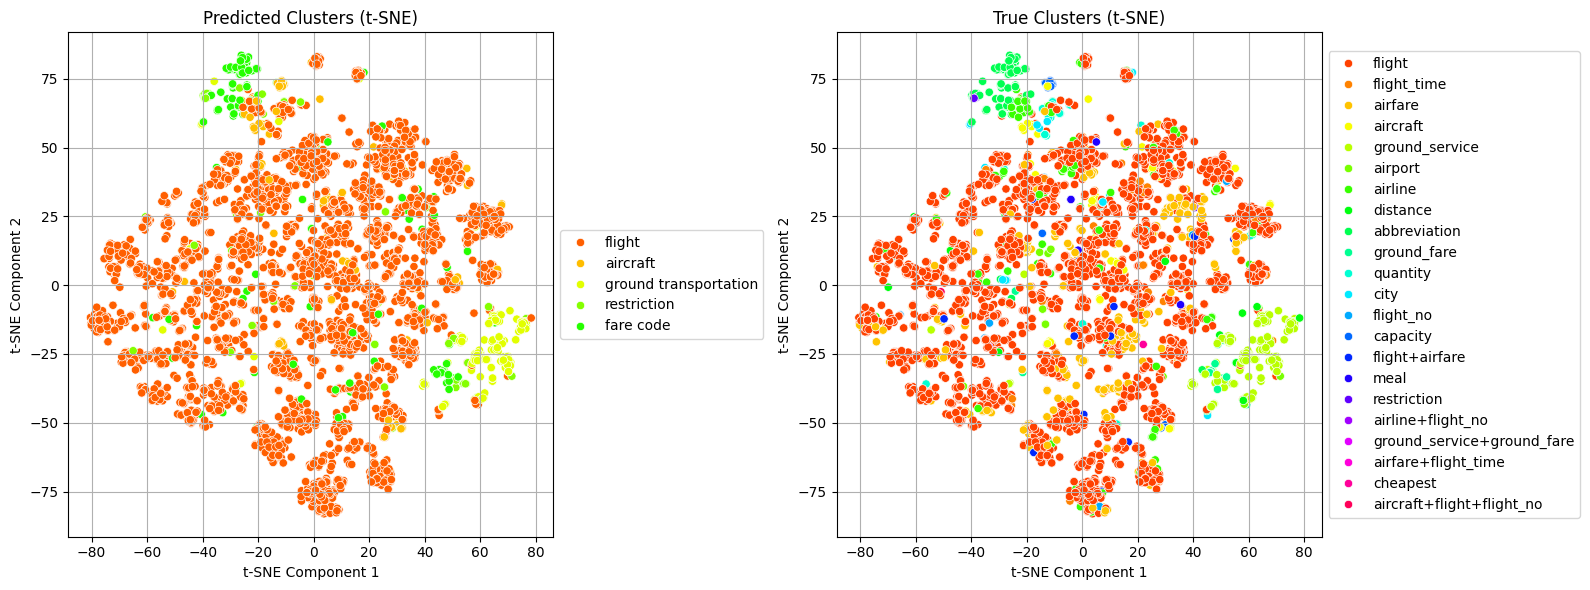

In [388]:
# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

### plot the predicted cluster
sns.scatterplot(ax=axes[0], x='Dimension 1', y='Dimension 2', hue='Cluster', palette=palette1, data=df)
axes[0].set_title('Predicted Clusters (t-SNE)')
axes[0].set_xlabel('t-SNE Component 1')
axes[0].set_ylabel('t-SNE Component 2')
axes[0].grid(True)

# plot the true cluster
sns.scatterplot(ax=axes[1], x='Dimension 1', y='Dimension 2', hue='True_cluster', palette=palette2, data=df)
axes[1].set_title('True Clusters (t-SNE)')
axes[1].set_xlabel('t-SNE Component 1')
axes[1].set_ylabel('t-SNE Component 2')
axes[1].grid(True)

### move the legned to outside the plot
axes[0].legend(loc='center left', bbox_to_anchor=(1, 0.5))
axes[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

#### Auto-Cluster example

In [389]:
index_list = np.random.choice(len(corpus), size=5, replace=False)
for index in index_list:
    print(f"text: {corpus[index]}")
    print(f"label: {new_label[index]}")
    print("=" * 30)

text: i want to travel from washington dc to philadelphia on tuesday morning
label: flight
text: from toronto to atlanta in the afternoon
label: flight
text: show me your flights from atlanta to denver on june fourth
label: flight
text: i need a flight from kansas city to chicago that leaves wednesday and arrives in chicago around 7 pm
label: flight
text: what transportation is available from the dallas airport to downtown
label: ground transportation


#### New text label example

In [395]:
text = "How do I drive from my home to JFK"

classifier = pipeline("zero-shot-classification",
                      model="facebook/bart-large-mnli")
    
output = classifier(text, candidate_intent)
print(f"text: {output['sequence']}")
print(f"labels: {output['labels'][0]}")


text: How do I drive from my home to JFK
labels: airport+transportation
